## Final Project - Part II
<b>Tom Borgstadt</b>
<br>BUS 6316S Advanced Topics in Analytics</br>

In [1]:
# numpy for arrays and matrices
import numpy as np

# pandas dataframe 
import pandas as pd

# pandas data reader for aquiring market data from Yahoo Finance
import pandas_datareader.data as web

from scipy.optimize import minimize

from __future__ import division

# graphing packages
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

debug = 0


In [2]:
# Pandas Time Series Period Codes

# B       business day frequency
# C       custom business day frequency (experimental)
# D       calendar day frequency
# W       weekly frequency
# M       month end frequency
# BM      business month end frequency
# CBM     custom business month end frequency
# MS      month start frequency
# BMS     business month start frequency
# CBMS    custom business month start frequency
# Q       quarter end frequency
# BQ      business quarter endfrequency
# QS      quarter start frequency
# BQS     business quarter start frequency
# A       year end frequency
# BA      business year end frequency
# AS      year start frequency
# BAS     business year start frequency
# BH      business hour frequency
# H       hourly frequency
# T       minutely frequency
# S       secondly frequency
# L       milliseonds
# U       microseconds
# N       nanoseconds


In [4]:
startDate = '2016-01-01'
endDate   = '2017-01-31'

# Input file of the desired ETF ticker symbols
# df_etf = pd.read_csv('ETF_Balancing_Input.csv')

# symbols_dict = {'symbol': ['SPY','UNG']}
# symbols_dict = {'symbol': ['SPY','TLH','GLD','RWR']}
# symbols_dict = {'symbol': ['GOOG','TSLA','XPO']}
# symbols_dict = {'symbol': ['IVV','MDY','VB','VEU','AGG','RWR','VNQI','IJT','TLH',
#                            'UDN','UUP','SLV','GLD','USO','UNG','USCI']}
# symbols_dict = {'symbol': ['TLH','UDN','UUP','SLV','GLD','USO','UNG','USCI']}
symbols_dict = {'symbol': ['IVV','MDY','VB','VEU','AGG', 'TLH','RWR','VNQI']}

df_etf = pd.DataFrame(symbols_dict)

# Initialize a dataframe for market returns
etf_returns_df = pd.DataFrame()

for idx, row in df_etf.iterrows():
    # Retrieve the ETF history
    df_sym = pd.DataFrame(web.get_data_yahoo(row['symbol'], start=startDate, end=endDate)['Adj Close'])
 
    # Resample the last value in the Business Month period
    period = 'W'
    df_sym_tser = df_sym.resample(period).apply(lambda x: x[-1])
    
    # Calculate percent change from period to period
    df_sym_tser_chg = df_sym_tser.pct_change(periods=1)
    df_sym_tser_chg.columns=[row['symbol']]

    etf_returns_df = etf_returns_df.join(df_sym_tser_chg, how='outer')

# Drop any NaN values
etf_returns_df.dropna(axis=0, inplace=True)
print '\nETF Returns: \n', etf_returns_df

# Output dataframe of returns for Excel analysis
etf_returns_df.to_csv('returns.csv')        

# Create a numpy array from the dataframe to be used as matrices later
etf_returns = np.asarray([etf_returns_df[col].values for col in etf_returns_df.columns])

# Capture number of assets
n_assets = len(etf_returns)



ETF Returns: 
                 IVV       MDY        VB       VEU       AGG       TLH  \
Date                                                                     
2016-01-17 -0.021210 -0.028551 -0.036418 -0.033622  0.002485  0.009523   
2016-01-24  0.014570  0.014327  0.012598  0.024303 -0.000826 -0.001959   
2016-01-31  0.016345  0.024025  0.018115  0.023476  0.004686  0.011924   
2016-02-07 -0.029647 -0.029754 -0.035781 -0.025866  0.001814  0.007923   
2016-02-14 -0.006884 -0.013271 -0.020075 -0.028056  0.004116  0.012994   
2016-02-21  0.028686  0.035518  0.039214  0.032732  0.000182 -0.003383   
2016-02-28  0.016690  0.026398  0.030267  0.000250  0.001548 -0.001344   
2016-03-06  0.027173  0.044680  0.046386  0.055140 -0.003274 -0.010478   
2016-03-13  0.011713  0.005723  0.006280  0.016789  0.000366 -0.006379   
2016-03-20  0.013393  0.015475  0.015701  0.008599  0.006854  0.010459   
2016-03-27 -0.011570 -0.010743 -0.016129 -0.018510 -0.000545 -0.001285   
2016-04-03  0.018562  0

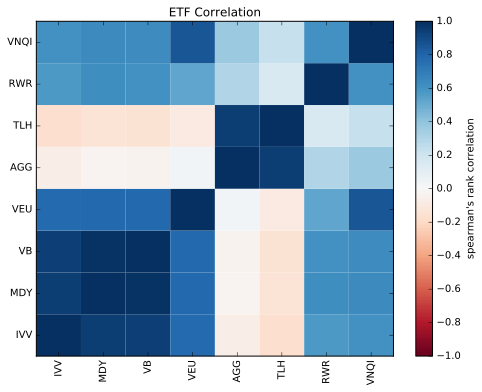

In [5]:
def plot_correlation(dataframe, corr_type, title='', filename=''):
    df_corr = dataframe.corr(method=corr_type)
    
    labels = df_corr.columns.tolist()
    tick_indices = np.arange(0.5, len(labels) + 0.5)
    plt.figure(figsize=(8,6))
    plt.pcolor(df_corr.values, cmap='RdBu', vmin=-1, vmax=1)
    colorbar = plt.colorbar()
    colorbar.set_label(corr_type + '\'s rank correlation')
    plt.title(title)
    plt.xticks(tick_indices, labels, rotation='vertical')
    plt.yticks(tick_indices, labels)
    if filename != '':
        plt.savefig(filename)
        df_corr.to_csv(filename + '.csv')
    return

plot_correlation(etf_returns_df, 'spearman', title='ETF Correlation', filename='ETF_Correlation')


## Scipy Optimize - Minimize Utility

In [6]:
rf  = .015   # Define Risk-free rate

W   = np.mat(np.full((1, n_assets), 1.00/n_assets, dtype=float))
ER  = np.mat(np.mean(etf_returns, axis=1))
COV = np.mat(np.cov(etf_returns))

def sharp_(weights, returns, covar, rfrate):
    mean = np.mat(weights) * np.mat(returns).transpose()
    stds = np.mat(weights) * np.mat(covar) * np.mat(weights).transpose()
    sharp_ratio = (mean - rfrate) / np.sqrt(stds)
    # Increasing Sharp Ratio indicates higher diversification (most desirable)
    # So to maximize Sharp Ratio we need to minimize the inverse of the Sharp Ratio
    return float(1.0/sharp_ratio)

def return_(weights, returns, covar):
    # By default, maximize this function by dividing 1.0 by the expected return (mean)
    mean = np.mat(weights) * np.mat(returns).transpose()
    return float(1.0/mean)

def risk_(weights, returns, covar):
    stds = np.mat(weights) * np.mat(covar) * np.mat(weights).transpose()
    return float(np.sqrt(stds))

b_ = [(0.05,1.) for i in range(n_assets)]              # set the same bounds for each asset 
c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1.0 })   # sum of weights = 100%

Results = pd.DataFrame(symbols_dict)


In [7]:
max_sharp = minimize(sharp_, W, args=(ER, COV, rf), method='SLSQP', bounds=b_, constraints=c_)

if not max_sharp.success: 
    print 'sharp_ not optimized: ', max_sharp.message
    #     raise BaseException(max_sharp.message)

Results = Results.join(pd.Series(max_sharp.x, name='max_sharp').round(4))


In [8]:
min_risk = minimize(risk_, W, args=(ER, COV), method='SLSQP', bounds=b_, constraints=c_)

if not min_risk.success: 
    print 'risk_ not optimized: ', min_risk.message
    #     raise BaseException(min_risk.message)

Results = Results.join(pd.Series(min_risk.x, name='min_risk').round(4))


In [9]:
max_return = minimize(return_, W, args=(ER, COV), method='SLSQP', bounds=b_, constraints=c_)

if not max_return.success: 
    print 'return_ not optimized: ', max_return.message
    #     raise BaseException(max_return.message)

Results = Results.join(pd.Series(max_return.x, name='max_return').round(4))


In [11]:
print Results

  symbol  max_sharp  min_risk  max_return
0    IVV       0.05      0.05        0.05
1    MDY       0.05      0.05        0.65
2     VB       0.65      0.05        0.05
3    VEU       0.05      0.05        0.05
4    AGG       0.05      0.65        0.05
5    TLH       0.05      0.05        0.05
6    RWR       0.05      0.05        0.05
7   VNQI       0.05      0.05        0.05


In [12]:
print ER

[[  3.45070387e-03   4.98138577e-03   4.80086188e-03   3.02405708e-03
    3.67477260e-04  -2.08602931e-05   1.73877745e-03   2.16984081e-03]]
